# Praktische Optimierung Blatt 05
### Tobias Lotz:  217856 <br>
### Alexander van der Staay:  185444

In [1]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from multiprocessing import Pool
from tqdm import tqdm
from functools import partial

### Aufgabe 1

In [2]:
def f(x): return 1.5 * x[0]**2 + x[1]**2 + 21 * np.sin(x[0]) * np.cos(x[1]) + 0.5 * (np.abs(x[0])**2 + np.abs(x[1])**2) 

In [3]:
np.random.seed(1)

(a) Threshold Accepting

In [4]:
def ThresholdAccepting(func : callable, X0 : np.ndarray, T0, gamma, iters=20):
    d = X0.shape[0]
    X = X0
    T = T0
    dist = multivariate_normal(np.zeros_like(X0), np.identity(d))
    for i in range(iters):
        Z = np.array(dist.rvs(1))
        Y = X + Z
        if func(Y) < func(X) + T:
            X = Y
        T = gamma * T
    return {'x' : X, 'fun' : func(X)}

In [5]:
xs_ta = []
funs_ta = []
for i in range(20):
    result = ThresholdAccepting(f, np.array([5,5]), 1, 0.5)
    xs_ta.append(result['x'])
    funs_ta.append(result['fun'])

(b) Simulated Annealing

In [6]:
def SimulatedAnnealing(func : callable, X0 : np.ndarray, T0, gamma, iters=20):
    d = X0.shape[0]
    X = X0
    T = T0
    dist = multivariate_normal(np.zeros_like(X0), np.identity(d))
    for i in range(iters):
        Z = np.array(dist.rvs(1))
        Y = X + Z
        fun_y = func(Y)
        fun_x = func(X)
        if fun_y < fun_x:
            X = Y
        elif fun_y > fun_x:
            U = np.random.uniform(1)
            if U < np.exp(-(fun_y - fun_x) / T):
                X = Y
        T = gamma * T
    return {'x' : X, 'fun' : func(X)}

In [7]:
xs_sa = []
funs_sa = []
for i in range(20):
    result = SimulatedAnnealing(f, np.array([5,5]), 1, 0.5)
    xs_sa.append(result['x'])
    funs_sa.append(result['fun'])

### Ergebnisse

In [8]:
funs_ta = np.array(funs_ta)
funs_sa = np.array(funs_sa)

funs_ta.sort()
funs_sa.sort()

mean_sa = funs_sa.mean()
median_sa = (funs_sa[9] + funs_sa[10]) / 2
std_sa = funs_sa.std()

mean_ta = funs_ta.mean()
median_ta = (funs_ta[9] + funs_ta[10]) / 2
std_ta = funs_ta.std()


In [9]:
print(f'Funktion >-----------< Mean >--------< Median >-------< Std >-')
print(f'--------------------------------------------------------------')
print(f'Threshold Accept      {mean_ta : .2f}\t      {median_ta : .2f}\t       {std_ta : .2f}')
print(f'--------------------------------------------------------------')
print(f'Simulated Annealing   {mean_sa : .2f}\t      {median_sa : .2f}\t       {std_sa : .2f}')

Funktion >-----------< Mean >--------< Median >-------< Std >-
--------------------------------------------------------------
Threshold Accept       5.18	       1.50	        11.62
--------------------------------------------------------------
Simulated Annealing    6.31	       1.51	        14.01


{'whiskers': [<matplotlib.lines.Line2D at 0x7ff128ce3730>,
 'caps': [<matplotlib.lines.Line2D at 0x7ff128ce3b50>,
 'boxes': [<matplotlib.lines.Line2D at 0x7ff128ce3490>],
 'medians': [<matplotlib.lines.Line2D at 0x7ff128c6f0d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7ff128c6f370>],
 'means': []}

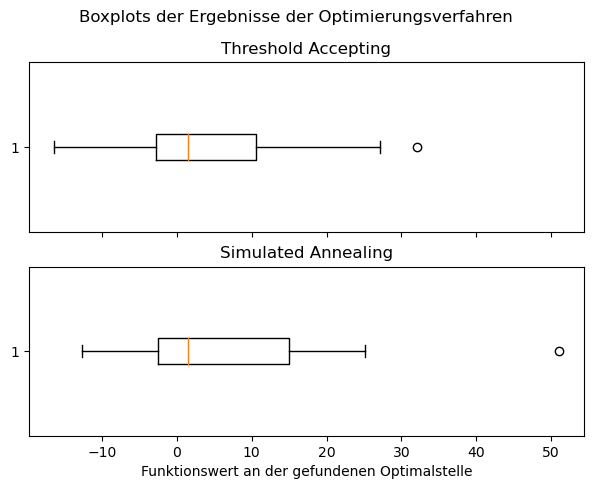

In [10]:
fig, ax = plt.subplots(2, sharex=True)
fig.suptitle('Boxplots der Ergebnisse der Optimierungsverfahren')
fig.tight_layout(pad=1.5)
plt.xlabel('Funktionswert an der gefundenen Optimalstelle')
ax[0].set_title('Threshold Accepting')
ax[0].boxplot(funs_ta, vert=False)
ax[1].set_title('Simulated Annealing')
ax[1].boxplot(funs_sa, vert=False)

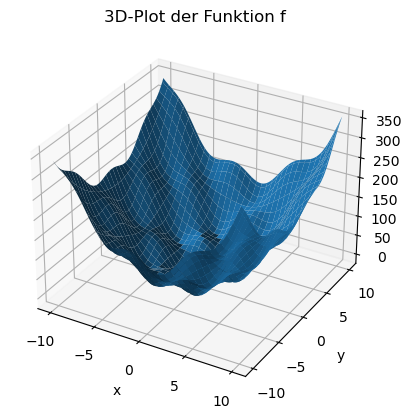

In [11]:
ax = plt.figure().add_subplot(projection='3d')

x = np.linspace(-10, 10, 101)
y = np.linspace(-10, 10, 101)
X, Y = np.meshgrid(x, y)
Z = 1.5 * X**2 + Y**2 + 21 * np.sin(X) * np.cos(Y) + 0.5 * (np.abs(X)**2 + np.abs(Y)**2) 

plt.title('3D-Plot der Funktion f')
plt.xlabel('x')
plt.ylabel('y')
ax.set_axisbelow(True)
ax.plot_surface(X, Y, Z)


### Interpretation

Die Threshold Accepting funktion scheint hier etwas bessere Ergebnisse zu liefern. Die Werte liegen im Mittel etwas tiefer und weisen eine geringere Streuung auf. Außerdem ist im Boxplot von Simulated Annealing zu sehen, dass hier 3 Outlierwerte vorliegen während bei TA nur ein Wert deutlich größer ist.

### Aufgabe 2

### Hilfsfunktion für übersichtlichen Code

In [12]:
def checkValid(solution : np.ndarray):
    s1 = solution[0] + solution[1] + solution[2]
    s2 = solution[3] + solution[4] + solution[5]
    s3 = solution[6] + solution[7] + solution[8]

    if not s1 == s2 == s3:
        return False
    
    s4 = solution[0] + solution[3] + solution[6]
    s5 = solution[1] + solution[4] + solution[7]
    s6 = solution[2] + solution[5] + solution[8]

    if not s4 == s5 == s6:
        return False
    
    s7 = solution[0] + solution[4] + solution[8]
    s8 = solution[6] + solution[4] + solution[2]

    return s7 == s8

### Rekombinationsfunktionen

In [13]:
def order_based_crossover(p1 : np.ndarray, p2 : np.ndarray):
    l = p1.shape[0]
    child = np.zeros_like(p1)
    ind = np.random.choice(np.arange(l), 2, replace=False)
    if ind[1] < ind[0]:
        tmp = ind[1]
        ind[1] = ind[0]
        ind[0] = tmp

    child[ind[0]:ind[1]+1] = p1[ind[0]:ind[1]+1]
    
    current_index = ind[1] + 1

    for i in range(ind[1]+1, ind[1]+1+l):
        if p2[i % l] not in child:
            child[current_index % l] = p2[i % l]
            current_index += 1
    
    return child

def partially_mapped_crossover(p1 : np.ndarray, p2 : np.ndarray):
    l = p1.shape[0]
    child = p2.copy()
    ind = np.random.choice(np.arange(l), 2, replace=False)
    if ind[1] < ind[0]:
        tmp = ind[1]
        ind[1] = ind[0]
        ind[0] = tmp
    
    for i in range(ind[0], ind[1]+1):
        j = np.where(child == p1[i])[0][0]
        tmp = child[i]
        child[i] = child[j]
        child[j] = tmp

    return child
        
def no_recombination(p1 : np.ndarray, p2 : np.ndarray):
    if np.random.choice(np.arange(2), 1)[0] == 0:
        return p1.copy()
    return p2.copy()

### Mutationsfunktionen

In [14]:
def two_swap(p):
    child = p.copy()
    ind = np.random.choice(np.arange(p.shape[0]), 2, replace=False)
    tmp = child[ind[0]]
    child[ind[0]] = child[ind[1]]
    child[ind[1]] = tmp
    return child

def one_translocation(p):
    child = p.copy()
    ind = np.random.choice(np.arange(p.shape[0]), 2, replace=False)
    if ind[1] < ind[0]:
        tmp = ind[0]
        ind[0] = ind[1]
        ind[1] = tmp
    tmp = child[ind[0]]
    for i in range(ind[0], ind[1]):
        child[i] = child[i+1]
    child[ind[1]] = tmp
    return child

def global_mutation(p : np.ndarray, k):
    child = p.copy()
    for i in range(k):
        child = two_swap(child)
    return child

def global_mutation_2(p : np.ndarray):
    return global_mutation(p, k=2)


def global_mutation_4(p : np.ndarray):
    return global_mutation(p, k=4)

### Zielfunktionen

In [15]:
def first(individual : np.ndarray):
    s1 = individual[0] + individual[1] + individual[2]
    s2 = individual[3] + individual[4] + individual[5]
    s3 = individual[6] + individual[7] + individual[8]
    s4 = individual[0] + individual[3] + individual[6]
    s5 = individual[1] + individual[4] + individual[7]
    s6 = individual[2] + individual[5] + individual[8]
    s7 = individual[0] + individual[4] + individual[8]
    s8 = individual[6] + individual[4] + individual[2]
    S = np.array([s1, s2, s3, s4, s5, s6, s7, s8])
    
    return S.max() - S.min()

def second(individual : np.ndarray):
    s1 = individual[0] + individual[1] + individual[2]
    s2 = individual[3] + individual[4] + individual[5]
    s3 = individual[6] + individual[7] + individual[8]
    s4 = individual[0] + individual[3] + individual[6]
    s5 = individual[1] + individual[4] + individual[7]
    s6 = individual[2] + individual[5] + individual[8]
    s7 = individual[0] + individual[4] + individual[8]
    s8 = individual[6] + individual[4] + individual[2]
    S = np.array([s1, s2, s3, s4, s5, s6, s7, s8])

    sum = 0
    for i in range(7):
        for j in range(i+1, 8):
            sum += np.abs(S[i] - S[j])
    return sum

def third(individual : np.ndarray):
    s1 = individual[0] + individual[1] + individual[2]
    s2 = individual[3] + individual[4] + individual[5]
    s3 = individual[6] + individual[7] + individual[8]
    s4 = individual[0] + individual[3] + individual[6]
    s5 = individual[1] + individual[4] + individual[7]
    s6 = individual[2] + individual[5] + individual[8]
    s7 = individual[0] + individual[4] + individual[8]
    s8 = individual[6] + individual[4] + individual[2]
    S = np.array([s1, s2, s3, s4, s5, s6, s7, s8])
    
    sum = 0
    for i in range(1, 8):
        sum += np.abs(S[i] - S[0])
    return sum


### EA

In [25]:
def magic_square_ea(fitness : callable, mu : int, lam : int, recombine : callable, mutate : callable):
    alphabet = np.arange(9) + 1
    parents = np.zeros((mu, 9))

    # Haltekriterium
    foundValidSolution = False
    
    # initiale Eltern generierung
    for i in range(mu):
        parents[i] = np.random.permutation(alphabet)

    fit_vals_parents = np.apply_along_axis(fitness, axis=1, arr=parents)
    count = parents.shape[0]

    # Hauptschleife
    while not foundValidSolution:
        
        children = np.zeros((lam, 9))
        # Rekombination der Eltern mit anschließender Mutation des Kindes
        for i in range(lam):
            # Auswahl von 2 unterschiedlichen Eltern
            indices = np.random.choice(np.arange(mu), 2, replace=False)
            p1 = parents[indices[0]]
            p2 = parents[indices[1]]
            # Mutation und Rekombination
            children[i] = mutate(recombine(p1, p2))

        population = np.concatenate([parents, children])
        fit_vals_children = np.apply_along_axis(fitness, axis=1, arr=children)

        fit_vals = np.concatenate([fit_vals_parents, fit_vals_children])
        count += children.shape[0]
        # wähle die mu besten Individuen
        ind = np.argpartition(fit_vals, mu)[:mu]
        parents = population[ind]
        fit_vals_parents = fit_vals[ind]

        # Überprüfe Haltekriterium
        for individual in parents:
            if checkValid(individual):
                return {'Quadrat' : individual, 'Anzahl' : count, 'mu' : mu, 
                        'lam' : lam, 'recombine' : recombine.__name__, 'mutation' : mutate.__name__
                        ,'fit' : fitness.__name__}

# Testen der Parameterkombinationen

In [26]:
mus = [5, 10, 20]
lambdas = [1, 5, 10]
#mutations = [two_swap, one_translocation, global_mutation_2, global_mutation_4]
mutations = [global_mutation_4]
recombinations = [order_based_crossover, partially_mapped_crossover, no_recombination]
fits = [first, second, third]

In [32]:
fit, mu, lam, rec, mut = np.meshgrid(fits, mus, lambdas, recombinations, mutations)

In [33]:
mu = mu.flatten()
lam = lam.flatten()
mut = mut.flatten()
rec = rec.flatten()
fit = fit.flatten()

# gloable Mutation mit k = 4

In [54]:
results_g4 = []
with Pool(81) as p:
    results_g4 = p.starmap(magic_square_ea, zip(fit, mu, lam, rec, mut))

In [55]:
vals_first = []
vals_second = []
vals_third = []

results_first = []
results_second = []
results_third = []

for res in results_g4:
    if res['fit'] == first.__name__:
        vals_first.append(res['Anzahl'])
        results_first.append(res)
    elif res['fit'] == second.__name__:
        vals_second.append(res['Anzahl'])
        results_second.append(res)
    else:
        vals_third.append(res['Anzahl'])
        results_third.append(res)

In [56]:
vals_first = np.array(vals_first)
vals_second = np.array(vals_second)
vals_third = np.array(vals_third)

results_first = np.array(results_first)
results_second = np.array(results_second)
results_third = np.array(results_third)

In [58]:
max_5_first = np.argpartition(vals_first, -5)[-5:]
max_5_second = np.argpartition(vals_second, -5)[-5:]
max_5_third = np.argpartition(vals_third, -5)[-5:]

min_5_first = np.argpartition(vals_first, 5)[:5]
min_5_second = np.argpartition(vals_second, 5)[:5]
min_5_third = np.argpartition(vals_third, 5)[:5]

In [88]:
best_5_first = results_first[min_5_first]
best_5_second = results_second[min_5_second]
best_5_third = results_third[min_5_third]

worst_5_first = results_first[max_5_first]
worst_5_second = results_second[max_5_second]
worst_5_third = results_third[max_5_third]

In [83]:
def print_result(res : dict):
    print(f'Mu: {res["mu"]}\tlambda: {res["lam"]}\tcombine: {res["recombine"]}\tmutate: {res["mutation"]}\t#Auswertungen: {res["Anzahl"]}')

In [101]:
print('Zielfunktion 1:\nTop-5:\n')
for res in best_5_first:
    print_result(res)
print('\nBottom-5:\n')
for res in worst_5_first:
    print_result(res)

Zielfunktion 1:
Top-5:

Mu: 5	lambda: 5	combine: partially_mapped_crossover	mutate: global_mutation_4	#Auswertungen: 570
Mu: 10	lambda: 10	combine: no_recombination	mutate: global_mutation_4	#Auswertungen: 1480
Mu: 10	lambda: 1	combine: partially_mapped_crossover	mutate: global_mutation_4	#Auswertungen: 1532
Mu: 10	lambda: 1	combine: no_recombination	mutate: global_mutation_4	#Auswertungen: 2286
Mu: 10	lambda: 1	combine: order_based_crossover	mutate: global_mutation_4	#Auswertungen: 2591

Bottom-5:

Mu: 5	lambda: 1	combine: order_based_crossover	mutate: global_mutation_4	#Auswertungen: 16903
Mu: 5	lambda: 5	combine: order_based_crossover	mutate: global_mutation_4	#Auswertungen: 22510
Mu: 20	lambda: 5	combine: order_based_crossover	mutate: global_mutation_4	#Auswertungen: 21220
Mu: 5	lambda: 10	combine: no_recombination	mutate: global_mutation_4	#Auswertungen: 21725
Mu: 10	lambda: 5	combine: order_based_crossover	mutate: global_mutation_4	#Auswertungen: 22830


In [99]:
print('Zielfunktion 2:\nTop-5:\n')
for res in best_5_second:
    print_result(res)
print('\nBottom-5:\n')
for res in worst_5_second:
    print_result(res)

Zielfunktion 2:
Top-5:

Mu: 20	lambda: 5	combine: order_based_crossover	mutate: global_mutation_4	#Auswertungen: 1010
Mu: 10	lambda: 1	combine: order_based_crossover	mutate: global_mutation_4	#Auswertungen: 1776
Mu: 5	lambda: 1	combine: partially_mapped_crossover	mutate: global_mutation_4	#Auswertungen: 1175
Mu: 10	lambda: 10	combine: partially_mapped_crossover	mutate: global_mutation_4	#Auswertungen: 1950
Mu: 20	lambda: 5	combine: partially_mapped_crossover	mutate: global_mutation_4	#Auswertungen: 2170

Bottom-5:

Mu: 20	lambda: 10	combine: no_recombination	mutate: global_mutation_4	#Auswertungen: 12000
Mu: 10	lambda: 1	combine: no_recombination	mutate: global_mutation_4	#Auswertungen: 17480
Mu: 20	lambda: 10	combine: order_based_crossover	mutate: global_mutation_4	#Auswertungen: 21120
Mu: 5	lambda: 10	combine: partially_mapped_crossover	mutate: global_mutation_4	#Auswertungen: 12285
Mu: 5	lambda: 10	combine: order_based_crossover	mutate: global_mutation_4	#Auswertungen: 18695


In [98]:
print('Zielfunktion 3:\nTop-5:\n')
for res in best_5_third:
    print_result(res)
print('\nBottom-5:\n')
for res in worst_5_third:
    print_result(res)

Zielfunktion 3:
Top-5:

Mu: 5	lambda: 5	combine: no_recombination	mutate: global_mutation_4	#Auswertungen: 3030
Mu: 10	lambda: 10	combine: no_recombination	mutate: global_mutation_4	#Auswertungen: 2410
Mu: 20	lambda: 1	combine: partially_mapped_crossover	mutate: global_mutation_4	#Auswertungen: 3216
Mu: 10	lambda: 5	combine: no_recombination	mutate: global_mutation_4	#Auswertungen: 5055
Mu: 5	lambda: 1	combine: order_based_crossover	mutate: global_mutation_4	#Auswertungen: 5486

Bottom-5:

Mu: 20	lambda: 1	combine: no_recombination	mutate: global_mutation_4	#Auswertungen: 39025
Mu: 10	lambda: 1	combine: no_recombination	mutate: global_mutation_4	#Auswertungen: 40474
Mu: 5	lambda: 10	combine: order_based_crossover	mutate: global_mutation_4	#Auswertungen: 50215
Mu: 20	lambda: 10	combine: partially_mapped_crossover	mutate: global_mutation_4	#Auswertungen: 54220
Mu: 10	lambda: 10	combine: order_based_crossover	mutate: global_mutation_4	#Auswertungen: 68550


# Ergebnisse

Ich konnte leider nicht alle Parameterkombinationen testen, da der EA für manche Kombinationen sehr lange in lokalen Minima stecken bleibt (ich habe die Ausführung nach ~3h abgebrochen). Von den Ergebissen die ich beobachten konnte scheint es mir so, als wären Parameter optimal, welche eine höhere Anzahl an Nachkommen haben und die für eine größere Abweichung von den Eltern sorgen. Dadurch bleibt der Algorithmus nicht so sehr in lokalen Minima stecken. Hat man pro Iteration nur 1 Nachkommen, welcher sich nur an einer Stelle von einem der Elternteile unterscheidet ist es sehr schwierig aus lokalen Minima wieder heraus zu kommen. Daher vermute ich, dass die Mutationsfunktion __global_k4__ die beste ist. <br> <br>

Für __global_k4__ scheint die Zielfunktion 1 die beste zu sein, gefolgt von 2 und dann 3. <br>
Die Parameterkombination: <br>
$\mu = 5$, $\lambda = 5$, Rekombination = partially-mapped crossover, Zielfunktion = 1 <br> 
war die beste bzgl. der Mutationsfunktion __global_k4__.